# Cyber Data Analytics, CS4035
## Lab assignment 1: Fraud detection
### April 2019

### Importing data from CSV file

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

data = pd.read_csv('./data_for_student_case.csv', sep = ',')
orig_shape = data.shape
data = data.dropna()

print("Number of NaN values omitted: ", orig_shape[0] - data.shape[0])

data.head()
data.shape
print(data.dtypes)

labels = data['simple_journal']
print("Number of non-fraud: ", np.sum(labels == 'Settled'), ", with ratio: ", np.sum(labels == 'Settled')/len(labels))
print("Number of fraud: ", np.sum(labels == 'Chargeback'), ", with ratio: ", np.sum(labels == 'Chargeback')/len(labels))
print("Number of fraud: ", np.sum(labels == 'Refused'), ", with ratio: ", np.sum(labels == 'Refused')/len(labels))

data.groupby(by = 'simple_journal').count()

Number of NaN values omitted:  15815
txid                              int64
bookingdate                      object
issuercountrycode                object
txvariantcode                    object
bin                             float64
amount                          float64
currencycode                     object
shoppercountrycode               object
shopperinteraction               object
simple_journal                   object
cardverificationcodesupplied     object
cvcresponsecode                   int64
creationdate                     object
accountcode                      object
mail_id                          object
ip_id                            object
card_id                          object
dtype: object
Number of non-fraud:  223165 , with ratio:  0.8127888639202817
Number of fraud:  345 , with ratio:  0.0012565239085541963
Number of fraud:  51057 , with ratio:  0.18595461217116405


,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
simple_journal,,,,,,,,,,,,,,,,
Chargeback,345,345,345,345,345,345,345,345,345,345,345,345,345,345,345,345
Refused,51057,51057,51057,51057,51057,51057,51057,51057,51057,51057,51057,51057,51057,51057,51057,51057
Settled,223165,223165,223165,223165,223165,223165,223165,223165,223165,223165,223165,223165,223165,223165,223165,223165


## Convesion of categorical data to numeric

In [2]:
data_cat = data.copy(True)

data_oneHot = pd.get_dummies(data, columns = ['issuercountrycode', 'txvariantcode', 'currencycode', 'shoppercountrycode', 'shopperinteraction', 'cardverificationcodesupplied', 'accountcode'])

char_cols = data.dtypes.pipe(lambda x: x[x == 'object']).index
label_mapping = {}

for c in char_cols:
    data[c], label_mapping[c] = pd.factorize(data[c])

# label_mapping

### HeatMap

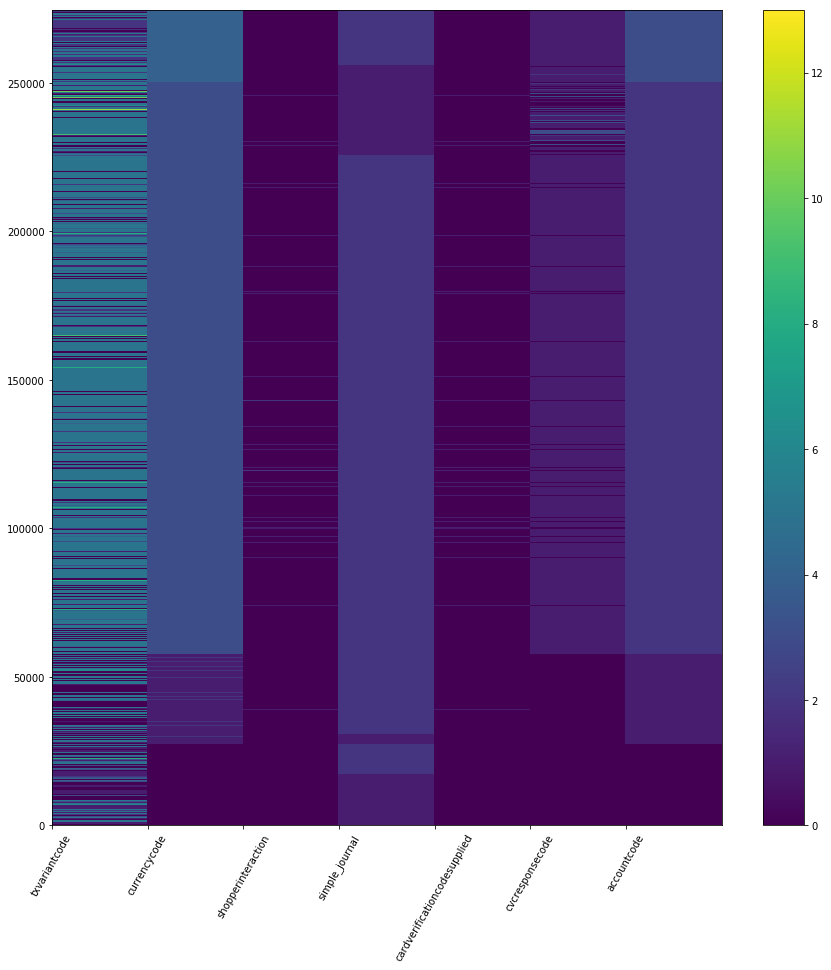

In [33]:
labels = ['txvariantcode', 'currencycode', 'shopperinteraction', 'simple_journal',  
          'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode']

plt.figure(figsize = (15,15))
plt.pcolor(data[labels])
plt.xticks(np.arange(len(labels)), labels, rotation = 60)
plt.colorbar()

### Aggregated values per card id

(223071, 6)


Text(0.5, 1.0, 'Fraud')

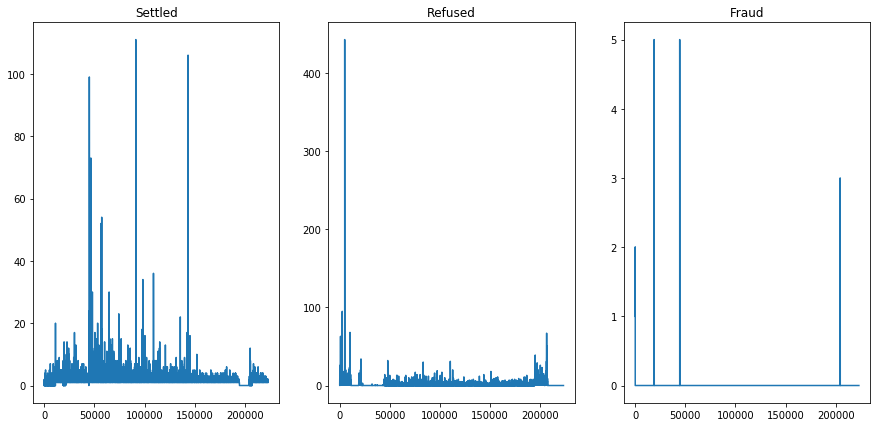

In [32]:
data_agg = data_cat[['card_id', 'simple_journal', 'amount']]

dd = pd.get_dummies(data_agg, columns = ['simple_journal'])

dd['sum_fraud'] = dd['amount'] * dd['simple_journal_Chargeback']
dd['sum_ref'] = dd['amount'] * dd['simple_journal_Refused']
dd['sum_OK'] = dd['amount'] * dd['simple_journal_Settled']

dd_user = dd.groupby(by = 'card_id', sort = False).agg({
    'simple_journal_Settled' : sum,
    'sum_OK' : 'mean',
    'simple_journal_Refused' : sum,
    'sum_ref' : 'mean',
    'simple_journal_Chargeback' : sum,
    'sum_fraud' : 'mean'
})

print(dd_user.values.shape)

# Visualizations
f, ax = plt.subplots(1, 3, figsize = (15,7))
ax[0].plot(dd_user.values[:, 0])
ax[0].set_title("Settled")
ax[1].plot(dd_user.values[:, 2])
ax[1].set_title("Refused")
ax[2].plot(dd_user.values[:, 4])
ax[2].set_title("Fraud")

In [43]:
test = data['bookingdate'].str.extract('(....-..-..)', expand=True)
test
tt = test[0].unique().sort()


None


### Visualizations

Text(0, 0.5, 'mean amount per group')

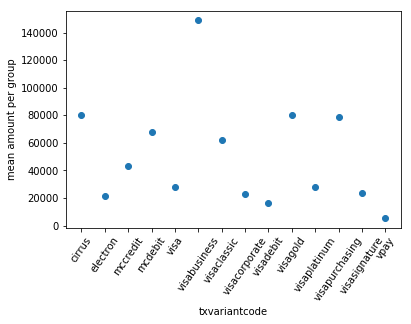

In [35]:
code = data_cat[['txvariantcode', 'amount']].groupby(['txvariantcode']).mean()
code.values
labels = code.index.values
plt.scatter(np.arange(len(code.values)), code.values)
plt.xticks(np.arange(len(code.values)), labels, rotation = '55')
plt.xlabel('txvariantcode')
plt.ylabel('mean amount per group')

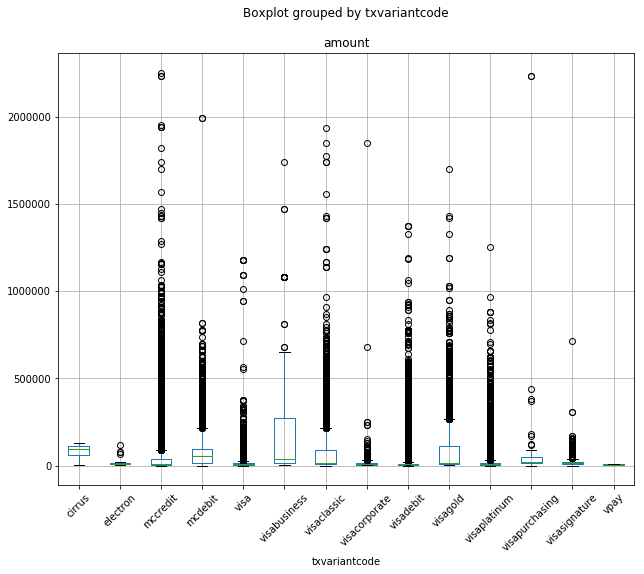

In [36]:
data_cat.boxplot(column = 'amount', by = 'txvariantcode', figsize = (10, 8), rot = '45')

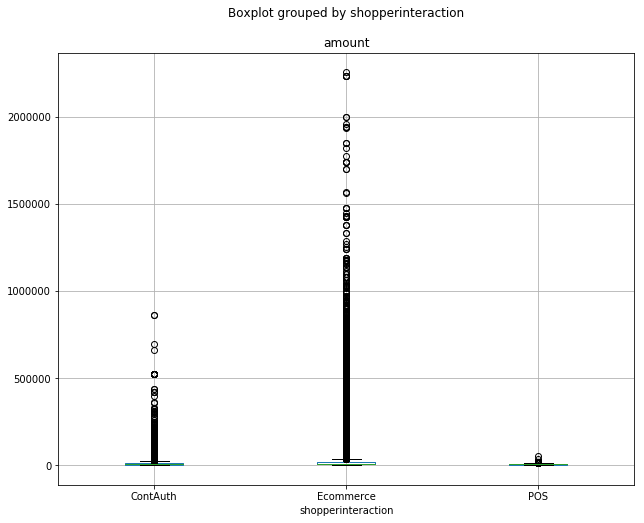

In [38]:
data_cat.boxplot(column = ['amount'], by = 'shopperinteraction', figsize = (10,8))

### Number of IP addresses per card id
#### The more addresses the more suspicious the transactions are

In [40]:
data_cat[['card_id', 'ip_id']].groupby('card_id').nunique().sort_values(by = 'ip_id', ascending = False).head()

,card_id,ip_id
card_id,,
card267365,1,25
card183189,1,25
card11998,1,23
card210128,1,22
card18592,1,20


## Classification

In [3]:
from sklearn.model_selection import train_test_split
from PlotConfusionMatrix import *

X = data.drop(['simple_journal', 'creationdate', 'bookingdate'], axis = 1).values
y = data['simple_journal'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

print(X_train.shape)
print(X_test.shape)

(247110, 14)
(27457, 14)


0.7870488400043705
Confusion matrix, without normalization
[[    3    14    18]
 [  263  2109  2839]
 [   50  2663 19498]]


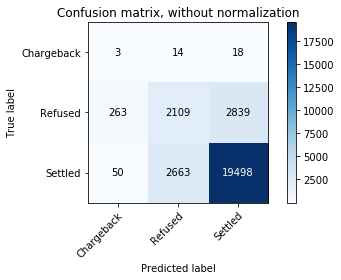

In [4]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

y_pred = clf.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes = np.array(['Chargeback', 'Refused', 'Settled']))

LR score:  0.8202644134464799
Confusion matrix, without normalization
[[    0     5    22]
 [    0   829  4447]
 [    0   461 21693]]


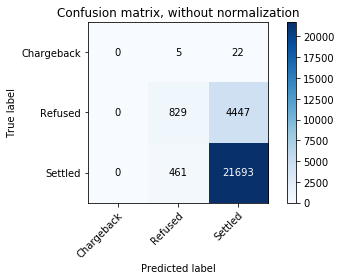

In [26]:
from  sklearn.linear_model import LogisticRegression as LR

clf = LR(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
clf.fit(X_train, y_train)
print("LR score: ", clf.score(X_test, y_test))

y_pred = clf.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes = np.array(['Chargeback', 'Refused', 'Settled']))

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF score:  1.0
Confusion matrix, without normalization
[[   27     0     0]
 [    0  5276     0]
 [    0     0 22154]]


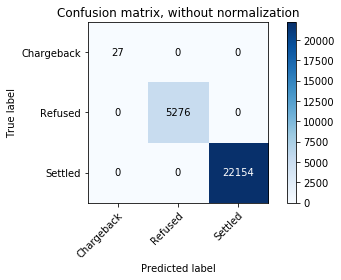

In [27]:
from  sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)
clf.fit(X_train, y_train)
print("RF score: ", clf.score(X_test, y_test))

y_pred = clf.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes = np.array(['Chargeback', 'Refused', 'Settled']))

LDA score:  0.8686673707979751
Confusion matrix, without normalization
[[    0    10    17]
 [    0  2997  2279]
 [    0  1300 20854]]


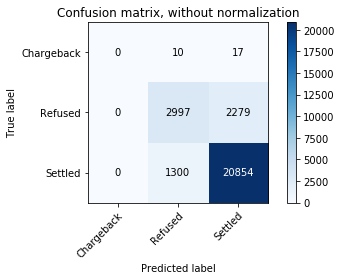

In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

clf = LDA(solver='svd')
clf.fit(X_train, y_train)
print("LDA score: ", clf.score(X_test, y_test))

y_pred = clf.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = np.array(['Chargeback', 'Refused', 'Settled']))

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA score:  0.8724915322140073
Confusion matrix, without normalization
[[    5     8    14]
 [    3  3375  1898]
 [    9  1569 20576]]


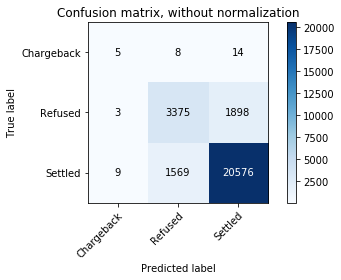

In [29]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

clf = QDA()

clf.fit(X_train, y_train)
print("QDA score: ", clf.score(X_test, y_test))

y_pred = clf.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = np.array(['Chargeback', 'Refused', 'Settled']))

KNN score:  0.9947190151873839
Confusion matrix, without normalization
[[   12    14     1]
 [    4  5236    36]
 [    1    89 22064]]


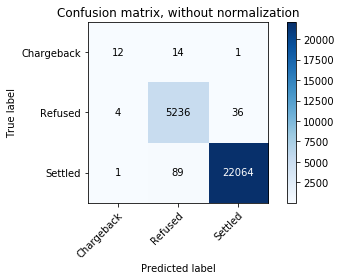

In [30]:
from sklearn.neighbors import KNeighborsClassifier as KNN

clf = KNN(n_neighbors=5, weights='distance', algorithm='auto', leaf_size=30, p=2, metric='minkowski', n_jobs=-1)
clf.fit(X_train, y_train)
print("KNN score: ", clf.score(X_test, y_test))

y_pred = clf.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = np.array(['Chargeback', 'Refused', 'Settled']))

AdaBoost score:  0.9897658156389991
Confusion matrix, without normalization
[[   21     1     5]
 [  275  5001     0]
 [    0     0 22154]]


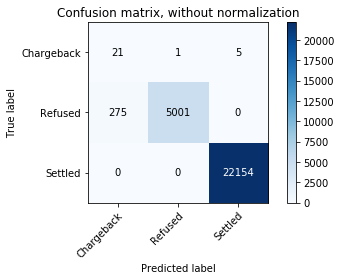

In [31]:
from sklearn.ensemble import AdaBoostClassifier as AdaBoost

clf = AdaBoost(n_estimators=50, learning_rate=1.0, algorithm='SAMME.R')
clf.fit(X_train, y_train)
print("AdaBoost score: ", clf.score(X_test, y_test))

y_pred = clf.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes = np.array(['Chargeback', 'Refused', 'Settled']))

### Dimensionality Reduction & Scaling

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as StandardScaler

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.fit_transform(X_test)

pca = PCA(n_components=0.95, whiten = True)
X_train_PCA = pca.fit_transform(X_train_scaled)
X_test_PCA = pca.transform(X_test_scaled)
pca.n_components_

(27457, 7)

KNN score:  0.9739228612011509
Confusion matrix, without normalization
[[    7    23     5]
 [    5  4926   280]
 [    2   401 21808]]


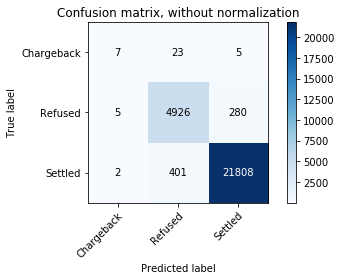

In [26]:
from sklearn.neighbors import KNeighborsClassifier as KNN

clf = KNN(n_neighbors=5, weights='distance', algorithm='auto', leaf_size=30, p=2, metric='minkowski', n_jobs=-1)
clf.fit(X_train_PCA, y_train)
print("KNN score: ", clf.score(X_test_PCA, y_test))

y_pred = clf.predict(X_test_PCA)

plot_confusion_matrix(y_test, y_pred, classes = np.array(['Chargeback', 'Refused', 'Settled']))